<a href="https://colab.research.google.com/github/saleh1312/CatsVsDogs-classification-CNN-with-Attention/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from os.path import join

In [36]:
f=4
sh=224
sw=224
shape=(int(sh/f),int(sw/f))

In [3]:
images_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/images_1000.npy')
parts_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/parts_1000.npy')
parts_encode_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/parts_encode_1000.npy')
labels_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/labels_1000.npy')

In [4]:
parts_encode_=parts_encode_.astype(np.float32)
labels_=labels_.astype(np.float32)

In [5]:
from sklearn.utils import shuffle
i_,p_,pe_,l_=shuffle(images_,parts_,parts_encode_,labels_)

In [6]:
input=tf.keras.Input((16,512))
h0,h1,c=tf.keras.layers.LSTM(100,return_sequences=True,return_state=True)(input)
d=tf.keras.layers.Dense(100,activation='tanh')(h1)
resh=tf.keras.layers.Reshape((1,100))(d)
attn_out ,attn_states= tf.keras.layers.Attention()(
    [resh, h0],return_attention_scores=True)
soft=tf.keras.layers.Softmax(axis=-1)(attn_states)
resh=tf.keras.layers.Reshape((100,))(attn_out)
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([d, resh])
dd=tf.keras.layers.Dense(16,activation='relu')(decoder_concat_input)
clas=tf.keras.layers.Dense(1,activation='sigmoid')(dd)

model=tf.keras.Model(input,clas)
model2=tf.keras.Model(input,[clas,soft])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 512)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 16, 100),    245200      ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 dense (Dense)                  (None, 100)          10100       ['lstm[0][1]']                   
                                                                                            

In [13]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.001))
model2.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.001))

In [ ]:
model.fit(pe_,l_,batch_size=32,epochs=100)

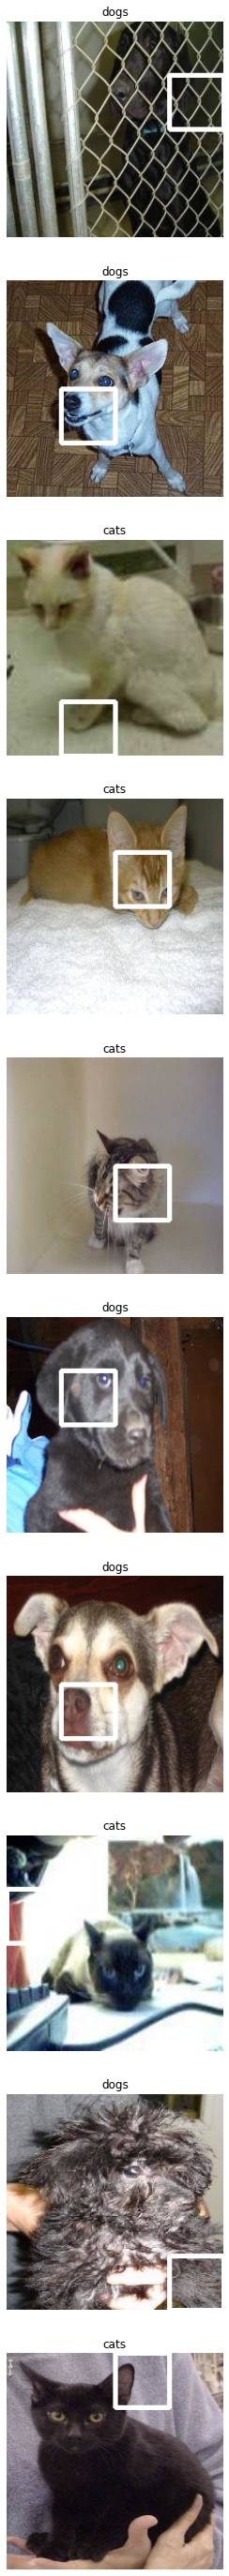

In [35]:
cat_enc={0:'cats',1:'dogs'}
i=np.random.randint(0,2000,(10))

fig = plt.figure(figsize=(50, 50))
for u in range(i.shape[0]):

  img=i_[i[u]].copy()
  pred,attn=model2.predict( np.reshape(pe_[i[u]] , (1,pe_.shape[1],pe_.shape[2]) ) )
  pred=np.round(pred[0,0]).astype(np.int32)
  pred = cat_enc[pred]
  ff=np.argmax(attn.reshape((16)))

  r=0
  for y in range(0,img.shape[0],shape[0]):
    for x in range(0,img.shape[1],shape[1]):
      if x/shape[0] + r ==ff:
        cv2.rectangle(img, (x,y),(x+shape[0],y+shape[1]), (255,255,255), 3)
    r+=4

  fig.add_subplot(10, 1, u+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(pred)
  
